<a href="https://colab.research.google.com/github/shrishatuladhar/AI-ML/blob/main/ShrishaTuladhar_Worksheet07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**NAME: SHRISHA TULADHAR**
**GROUP: L6CG7**

# **WORKSHEET 7**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## **LOADING THE DATASET**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

train_dir = "/content/drive/MyDrive/Ai ML/Week4/DevanagariHandwrittenDigitDataset/Train"
test_dir = "/content/drive/MyDrive/Ai ML/Week4/DevanagariHandwrittenDigitDataset/Test"
img_size = (32, 32)

def load_dataset(directory, img_size=(32, 32)):
    """Load images from directory structure"""
    images = []
    for digit_dir in os.listdir(directory):
        digit_path = os.path.join(directory, digit_dir)
        if os.path.isdir(digit_path):
            for img_file in os.listdir(digit_path):
                if img_file.endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(digit_path, img_file)
                    img = Image.open(img_path).convert('L')
                    img = img.resize(img_size)
                    images.append(np.array(img))
    return np.array(images)

print("Loading training data...")
X_train = load_dataset(train_dir)
print("Loading test data...")
X_test = load_dataset(test_dir)
print(f"Training shape: {X_train.shape}, Test shape: {X_test.shape}")

Loading training data...
Loading test data...
Training shape: (17000, 32, 32), Test shape: (3000, 32, 32)


## **DATA PREPROCESSING**

Sample training images:


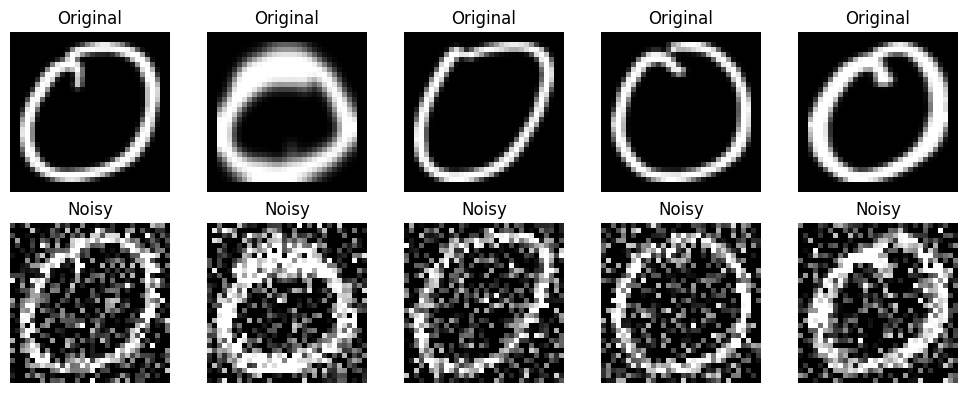

In [ ]:
def preprocess_data(images):
    """Normalize and reshape images"""
    images = images.astype('float32') / 255.
    images = np.expand_dims(images, axis=-1)
    return images

def add_noise(images, noise_factor=0.4):
    """Add Gaussian noise to images"""
    noisy = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    return np.clip(noisy, 0., 1.)

X_train_clean = preprocess_data(X_train)
X_test_clean = preprocess_data(X_test)

noise_factor = 0.4
X_train_noisy = add_noise(X_train_clean, noise_factor)
X_test_noisy = add_noise(X_test_clean, noise_factor)

def show_samples(clean, noisy, n=5):
    plt.figure(figsize=(10, 4))
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(clean[i].squeeze(), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        plt.subplot(2, n, i+n+1)
        plt.imshow(noisy[i].squeeze(), cmap='gray')
        plt.title("Noisy")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("Sample training images:")
show_samples(X_train_clean, X_train_noisy)

## **BUILDNIG AUTOENCODER**

In [ ]:
def build_devanagari_autoencoder(input_shape=(32, 32, 1)):
    """Build 6-layer convolutional autoencoder"""

    input_img = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    encoded = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    # Decoder
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)

    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001),
                       loss='binary_crossentropy')

    return autoencoder

autoencoder = build_devanagari_autoencoder()
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 1)      │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 314,625 (1.20 MB)

 Trainable params: 314,625 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

## **TRAINING MODEL**

Epoch 1/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - loss: 0.3582 - psnr: 11.9849 - ssim: 0.4152 - val_loss: 0.1575 - val_psnr: 18.0007 - val_ssim: 0.8363
Epoch 2/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - loss: 0.1543 - psnr: 18.1718 - ssim: 0.8465 - val_loss: 0.1465 - val_psnr: 19.1539 - val_ssim: 0.8742
Epoch 3/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - loss: 0.1447 - psnr: 19.1472 - ssim: 0.8745 - val_loss: 0.1416 - val_psnr: 19.6873 - val_ssim: 0.8914
Epoch 4/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - loss: 0.1409 - psnr: 19.6266 - ssim: 0.8879 - val_loss: 0.1416 - val_psnr: 19.5105 - val_ssim: 0.8813
Epoch 5/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - loss: 0.1383 - psnr: 19.9304 - ssim: 0.8959 - val_loss: 0.1381 - val_psnr: 20.1210 - val_ssim: 0.9030
Epoch 6/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - loss: 0.1370 - psnr: 20.1104 - ssim: 0.9006 - val_loss: 0.1356 - val_psnr: 20.4015 - val_ssim: 0.9056
Epoch 7/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - los

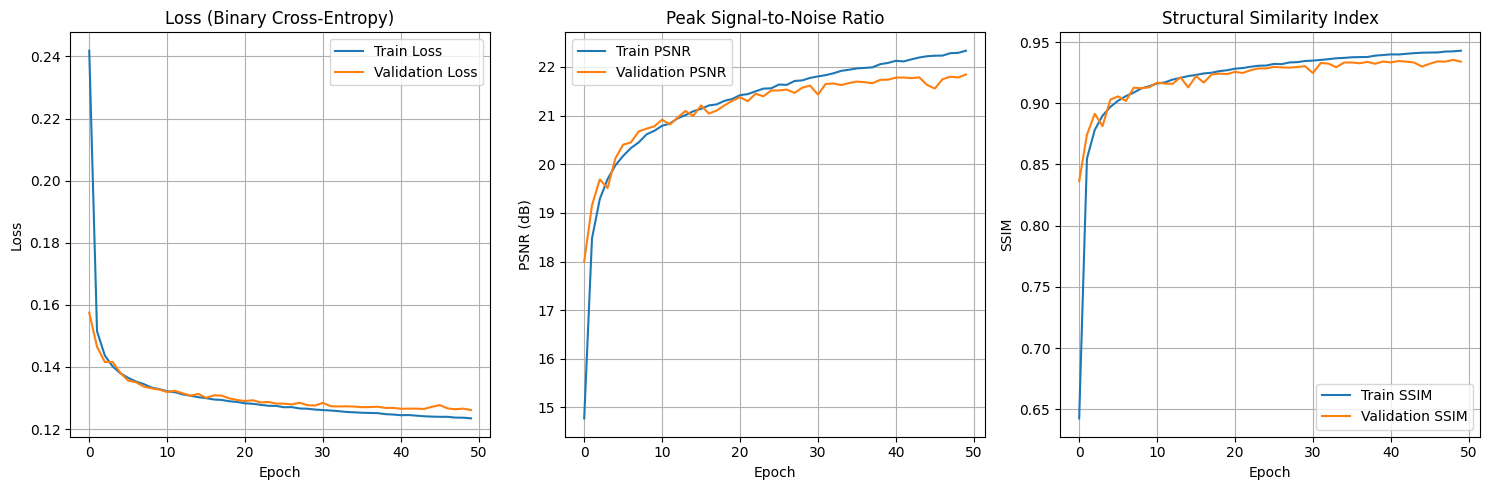

In [ ]:
from tensorflow.keras import backend as K
import tensorflow as tf

def psnr(y_true, y_pred):
    """Peak Signal-to-Noise Ratio (higher is better)"""
    mse = K.mean(K.square(y_true - y_pred))
    return 20 * K.log(1.0 / K.sqrt(mse)) / K.log(10.0)

def ssim(y_true, y_pred):
    """Structural Similarity Index (range 0-1, higher is better)"""
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

batch_size = 128
epochs = 50

autoencoder.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=[psnr, ssim])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = autoencoder.fit(
    X_train_noisy, X_train_clean,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(X_test_noisy, X_test_clean),
    callbacks=[early_stop]
)

def plot_training(history):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss (Binary Cross-Entropy)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(history.history['psnr'], label='Train PSNR')
    plt.plot(history.history['val_psnr'], label='Validation PSNR')
    plt.title('Peak Signal-to-Noise Ratio')
    plt.xlabel('Epoch')
    plt.ylabel('PSNR (dB)')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(history.history['ssim'], label='Train SSIM')
    plt.plot(history.history['val_ssim'], label='Validation SSIM')
    plt.title('Structural Similarity Index')
    plt.xlabel('Epoch')
    plt.ylabel('SSIM')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training(history)

## **EVALUATION AND RESULTS**

Test set results:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Mean Squared Error: 0.0062


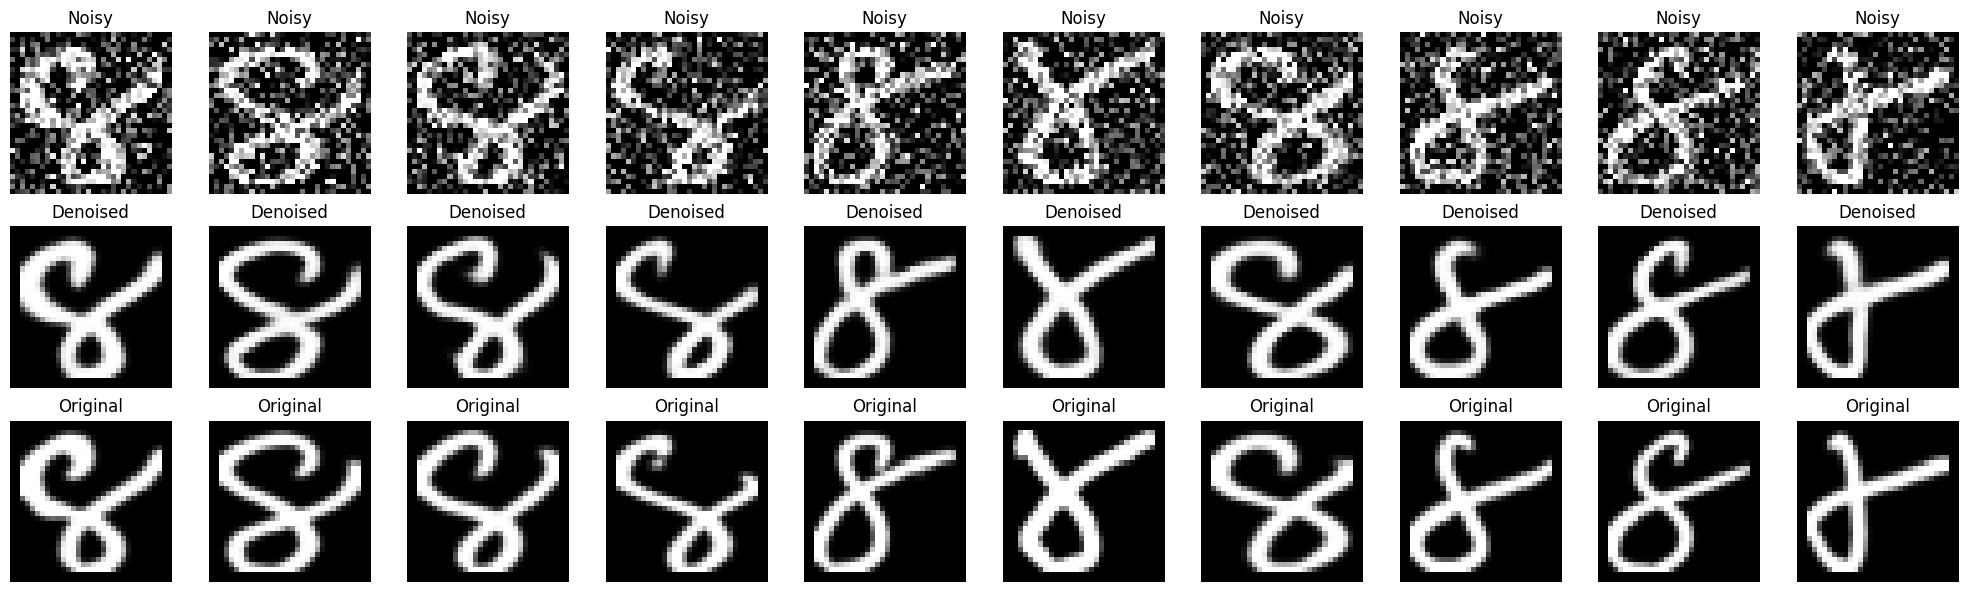

In [ ]:
def evaluate_and_visualize(model, test_noisy, test_clean, n=10):
    """Evaluate model and show results"""
    denoised = model.predict(test_noisy[:n])

    mse = np.mean(np.square(test_clean[:n] - denoised))
    print(f"Mean Squared Error: {mse:.4f}")

    plt.figure(figsize=(20, 6))
    for i in range(n):
        plt.subplot(3, n, i+1)
        plt.imshow(test_noisy[i].squeeze(), cmap='gray')
        plt.title("Noisy")
        plt.axis('off')

        plt.subplot(3, n, i+1+n)
        plt.imshow(denoised[i].squeeze(), cmap='gray')
        plt.title("Denoised")
        plt.axis('off')

        plt.subplot(3, n, i+1+2*n)
        plt.imshow(test_clean[i].squeeze(), cmap='gray')
        plt.title("Original")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

print("Test set results:")
evaluate_and_visualize(autoencoder, X_test_noisy, X_test_clean)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


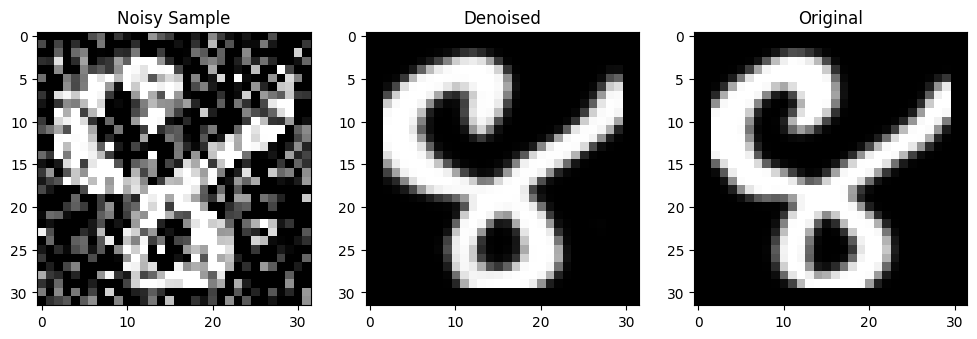

In [ ]:
def evaluate_and_visualize(model, test_noisy, test_clean, n=10):
    """Corrected visualization function"""
    denoised = model.predict(test_noisy[:n])

    plt.figure(figsize=(20, 6))
    for i in range(n):
        plt.subplot(3, n, i+1)
        plt.imshow(test_noisy[i].reshape(32, 32),  # Remove channel dim
                  cmap='gray', vmin=0, vmax=1)  # Explicit scale
        plt.title("Noisy")
        plt.axis('off')

        plt.subplot(3, n, i+1+n)
        plt.imshow(denoised[i].reshape(32, 32),
                  cmap='gray', vmin=0, vmax=1)
        plt.title("Denoised")
        plt.axis('off')

        plt.subplot(3, n, i+1+2*n)
        plt.imshow(test_clean[i].reshape(32, 32),
                  cmap='gray', vmin=0, vmax=1)
        plt.title("Original")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

sample_idx = 0
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(X_test_noisy[sample_idx].reshape(32, 32), cmap='gray')
plt.title("Noisy Sample")
plt.subplot(1, 3, 2)
plt.imshow(autoencoder.predict(X_test_noisy[sample_idx:sample_idx+1])[0].reshape(32, 32), cmap='gray')
plt.title("Denoised")
plt.subplot(1, 3, 3)
plt.imshow(X_test_clean[sample_idx].reshape(32, 32), cmap='gray')
plt.title("Original")
plt.show()